In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
from BaySS.utils import get_th_alpha

In [218]:
B_exp = 9
N = 5000
eps_list = np.geomspace(0.1, 5, 10)
alpha_test = 0.05

eps_to_idx = {eps: i for i, eps in enumerate(eps_list)}

In [216]:
c_list = [0.3, 0.6, 1., 1.5, 2.]
folder_name = "final_gretta_price_optimized"
success_list = []
coins_list = []
errors_list = []
label_list = []
alpha_list = []
for c in c_list:
    c_str = f"{c:.2f}".replace(".", "")
    with open(f"results/{folder_name}/N_{N}/B_exp_{B_exp}/c_{c_str}/success.pkl", "rb") as f:
        success = pickle.load(f)
    with open(f"results/{folder_name}/N_{N}/B_exp_{B_exp}/c_{c_str}/coins.pkl", "rb") as f:
        coins = pickle.load(f)
    with open(f"results/{folder_name}/N_{N}/B_exp_{B_exp}/c_{c_str}/errors.pkl", "rb") as f:
        errors = pickle.load(f)
    success_list.append(success)
    coins_list.append(coins)
    errors_list.append(errors)
    label_list.append(f"BaySS with c = {c}, alpha = {get_th_alpha(4 ** B_exp, N, c):.2f}")
    alpha_list.append(get_th_alpha(4 ** B_exp, N, c))

# add naive noisy
with open(f"results/naive_noisy_binary_search/N_{N}/B_exp_{B_exp}/success.pkl", "rb") as f:
    success = pickle.load(f)
with open(f"results/naive_noisy_binary_search/N_{N}/B_exp_{B_exp}/coins.pkl", "rb") as f:
    coins = pickle.load(f)
with open(f"results/naive_noisy_binary_search/N_{N}/B_exp_{B_exp}/errors.pkl", "rb") as f:
    errors = pickle.load(f)
success_list.append(success)
coins_list.append(coins)
errors_list.append(errors)
label_list.append("Naive noisy")

# add hierarchical
with open(f"results/hierarchical_mechanism/N_{N}/B_exp_{B_exp}/success.pkl", "rb") as f:
    success = pickle.load(f)
with open(f"results/hierarchical_mechanism/N_{N}/B_exp_{B_exp}/coins.pkl", "rb") as f:
    coins = pickle.load(f)
with open(f"results/hierarchical_mechanism/N_{N}/B_exp_{B_exp}/errors.pkl", "rb") as f:
    errors = pickle.load(f)
success_list.append(success)
coins_list.append(coins)
errors_list.append(errors)
label_list.append("Hierarchical Mechanism")

# import data
def upload_data(N: int, B_exp: int):
    folder_name = f"data/N_{N}/B_exp_{B_exp}"
    output = {}
    # import data
    with open(f'{folder_name}/pareto_data.pkl', 'rb') as f:
        data = pickle.load(f)
    output["data"] = data

    # import bins
    with open(f'{folder_name}/pareto_bins.pkl', 'rb') as f:
        bins = pickle.load(f)
    output["bins"] = bins

    # import intervals
    with open(f'{folder_name}/pareto_intervals.pkl', 'rb') as f:
        intervals = pickle.load(f)
    output["intervals"] = intervals

    # import median
    with open(f'{folder_name}/pareto_median.pkl', 'rb') as f:
        median = pickle.load(f)
    output["median"] = median

    # import median quantile
    with open(f'{folder_name}/pareto_median_quantile.pkl', 'rb') as f:
        median_quantile = pickle.load(f)
    output["median_quantile"] = median_quantile

    # import cdf
    with open(f'{folder_name}/pareto_cdf.pkl', 'rb') as f:
        cf_dict = pickle.load(f)
    output["cf_dict"] = cf_dict

    return output


data = upload_data(N, B_exp)

In [217]:
data["median"]

1198

In [196]:
markers = ["-", "--", "-.", ":", "-o", "-s", "-D", "-^", "-v", "-<", "->", "-p", "-h"]
colors = ["blue", "red", "green", "orange", "purple", "black", "brown", "pink", "gray", "olive", "cyan", "magenta"]

# Success rate

In [197]:
def get_binomial_std(p, n):
    return np.sqrt(p * (1 - p) / n)

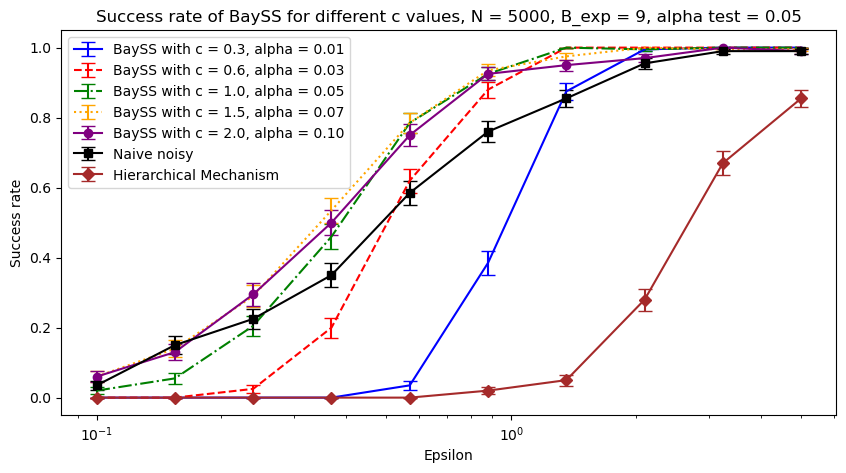

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i, success in enumerate(success_list):
    c_str = f"{c:.2f}".replace(".", "")
    ax.errorbar(eps_list,
                np.mean(success, axis=1),
                yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]),
                fmt=markers[i],
                label=label_list[i],
                color=colors[i],
                capsize=5)
ax.set_xlabel("Epsilon")
ax.set_ylabel("Success rate")
ax.set_title(f"Success rate of BaySS for different c values, N = {N}, B_exp = {B_exp}, alpha test = {alpha_test}")
ax.set_xscale("log")
ax.legend()
plt.show()

# Differente success rate

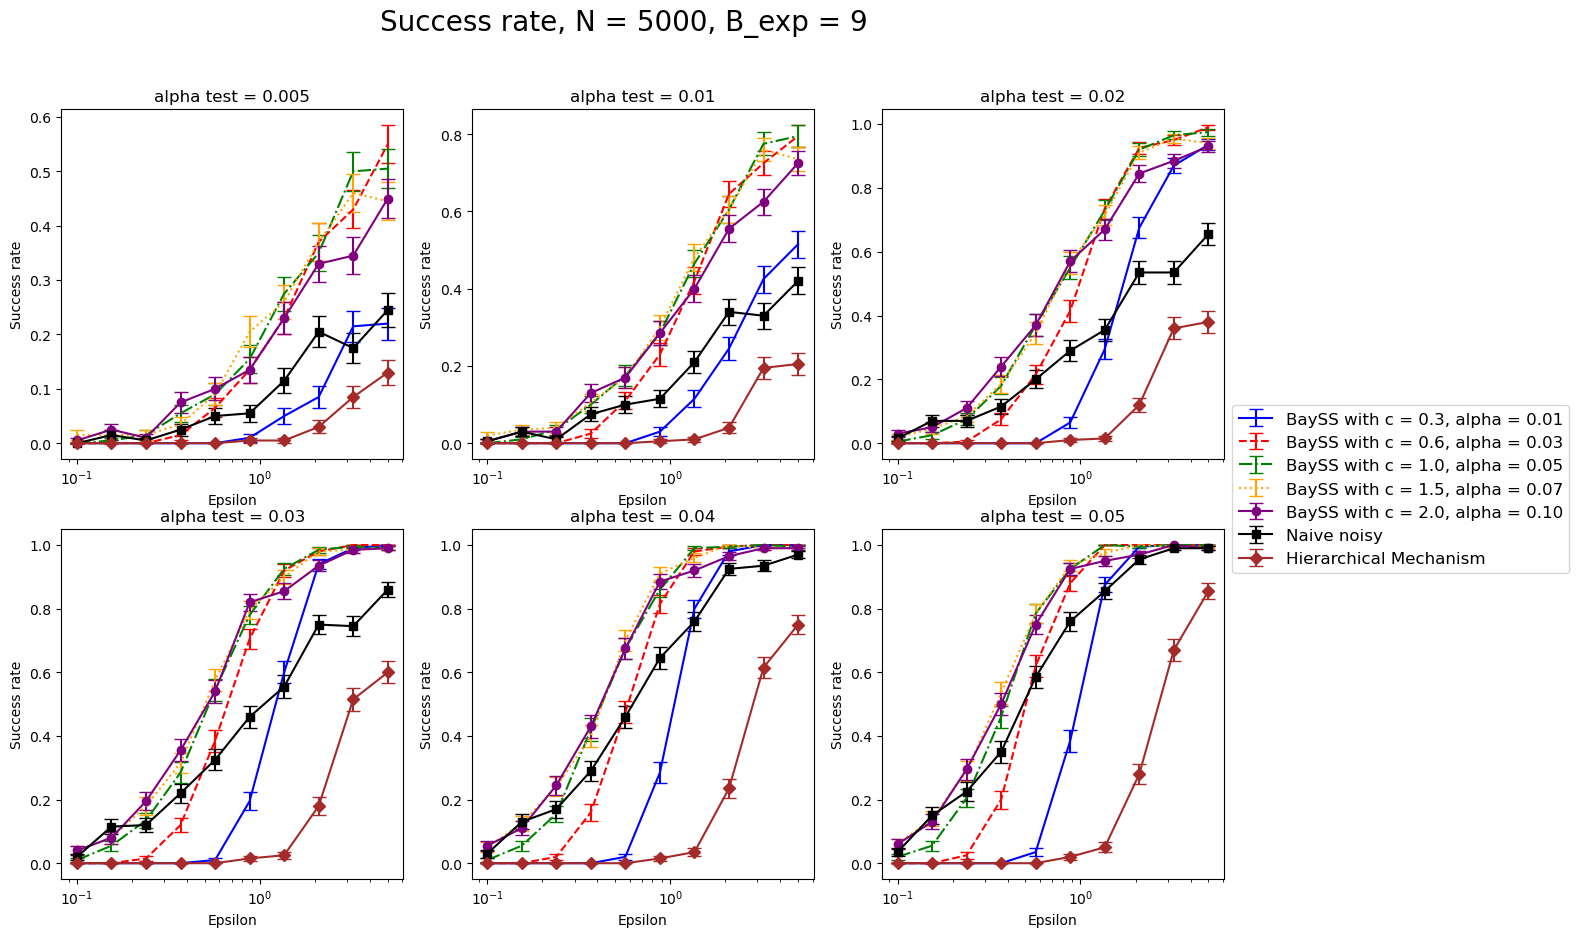

In [199]:
def get_success(coin, cf_dict, alpha, target):
    coin = int(coin)
    if coin not in cf_dict.keys():
        for index in reversed(range(coin)):
            if index in cf_dict.keys():
                coin = index
                break
    if target - alpha < cf_dict[coin] < target + alpha:
        success = True
    else:
        success = False
    return int(success)


fig, axs = plt.subplots(2, 3, figsize=(15, 10))
alpha_test_list = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]

for fig_index, alpha_test in enumerate(alpha_test_list):
    ax = axs[fig_index // 3, fig_index % 3]  # Access subplot correctly
    for i, coins in enumerate(coins_list):
        c_str = f"{c:.2f}".replace(".", "")
        success = np.zeros((len(eps_list), len(coins[0])))
        for j in range(len(eps_list)):
            for c, coin in enumerate(coins[j]):
                success[j, c] = get_success(coin, data["cf_dict"], alpha_test, 0.5)
        ax.errorbar(eps_list,
                               np.mean(success, axis=1),
                               yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]),
                               fmt=markers[i],
                               label=label_list[i],
                               color=colors[i],
                               capsize=5)
    ax.set_xlabel("Epsilon")
    ax.set_ylabel("Success rate")
    ax.set_title(f"alpha test = {alpha_test}")
    ax.set_xscale("log")
# make unique legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=12)
fig.suptitle(f"Success rate, N = {N}, B_exp = {B_exp}", fontsize=20)

# save figure
folder_name = "final"
if not os.path.exists(f"figures/{folder_name}"):
    os.makedirs(f"figures/{folder_name}")
plt.savefig(f"figures/{folder_name}/success_rate_N_{N}_B_exp_{B_exp}.png", bbox_inches='tight')

plt.show()

# Error

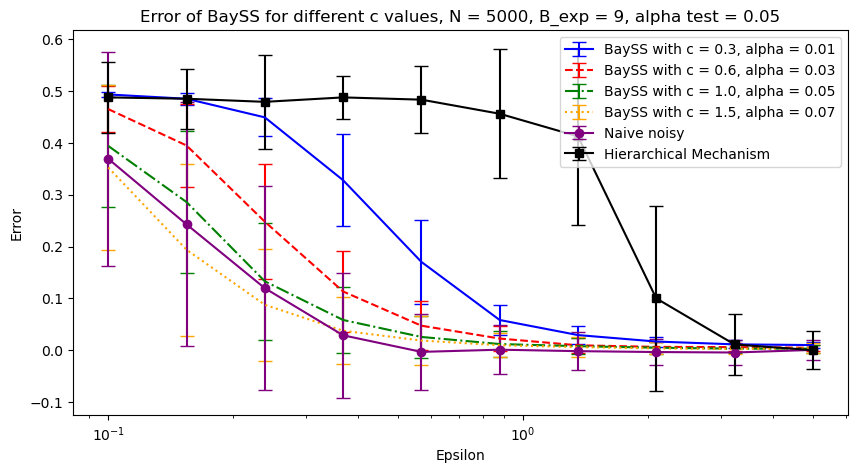

In [184]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i, errors in enumerate(errors_list):
    c_str = f"{c:.2f}".replace(".", "")
    ax.errorbar(eps_list,
                np.mean(errors, axis=1),
                yerr=np.std(errors, axis=1),
                fmt=markers[i],
                label=label_list[i],
                color=colors[i],
                capsize=5)
ax.set_xlabel("Epsilon")
ax.set_ylabel("Error")
ax.set_title(f"Error of BaySS for different c values, N = {N}, B_exp = {B_exp}, alpha test = {alpha_test}")
ax.set_xscale("log")
ax.legend()
plt.show()

# Absolute error

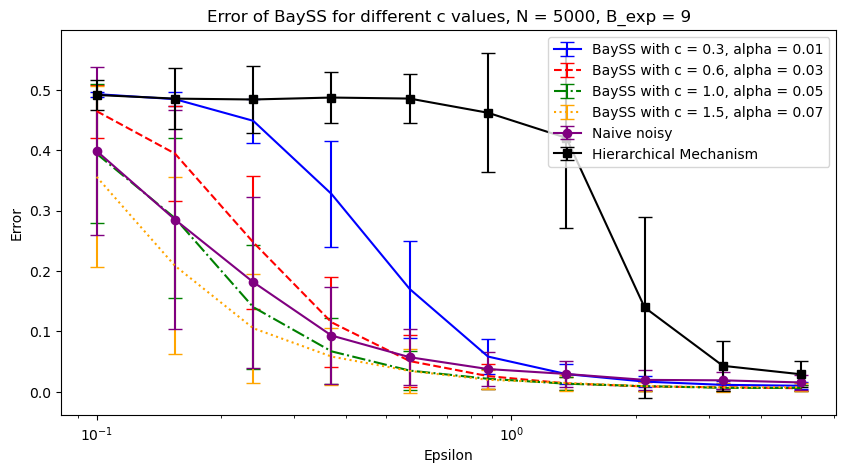

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i, errors in enumerate(errors_list):
    c_str = f"{c:.2f}".replace(".", "")
    ax.errorbar(eps_list,
                np.mean(np.abs(errors), axis=1),
                yerr=np.std(np.abs(errors), axis=1),
                fmt=markers[i],
                label=label_list[i],
                color=colors[i],
                capsize=5)
ax.set_xlabel("Epsilon")
ax.set_ylabel("Error")
ax.set_title(f"Error of BaySS for different c values, N = {N}, B_exp = {B_exp}")
ax.set_xscale("log")
ax.legend()
plt.show()

# CDF

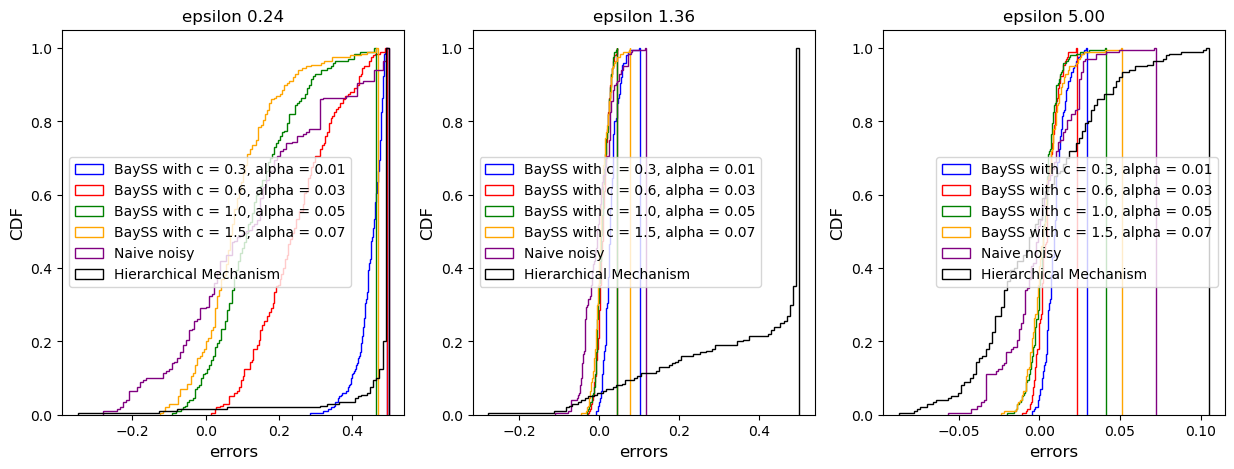

In [187]:
# make three plots in a row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, eps_id in enumerate([2, 6, 9]):
    eps = eps_list[eps_id]

    eps_id = eps_to_idx[eps]

    for j in range(len(c_list) + 2):
        errors = errors_list[j]
        axs[i].hist(errors[eps_id], bins=100, density=True, histtype='step', cumulative=True, label=label_list[j],
                    color=colors[j])
    axs[i].set_xlabel('errors', fontsize=12)
    axs[i].set_ylabel('CDF', fontsize=12)
    axs[i].set_title(f"epsilon {eps:.2f}")
    axs[i].legend()
plt.show()

# CDF Reverse

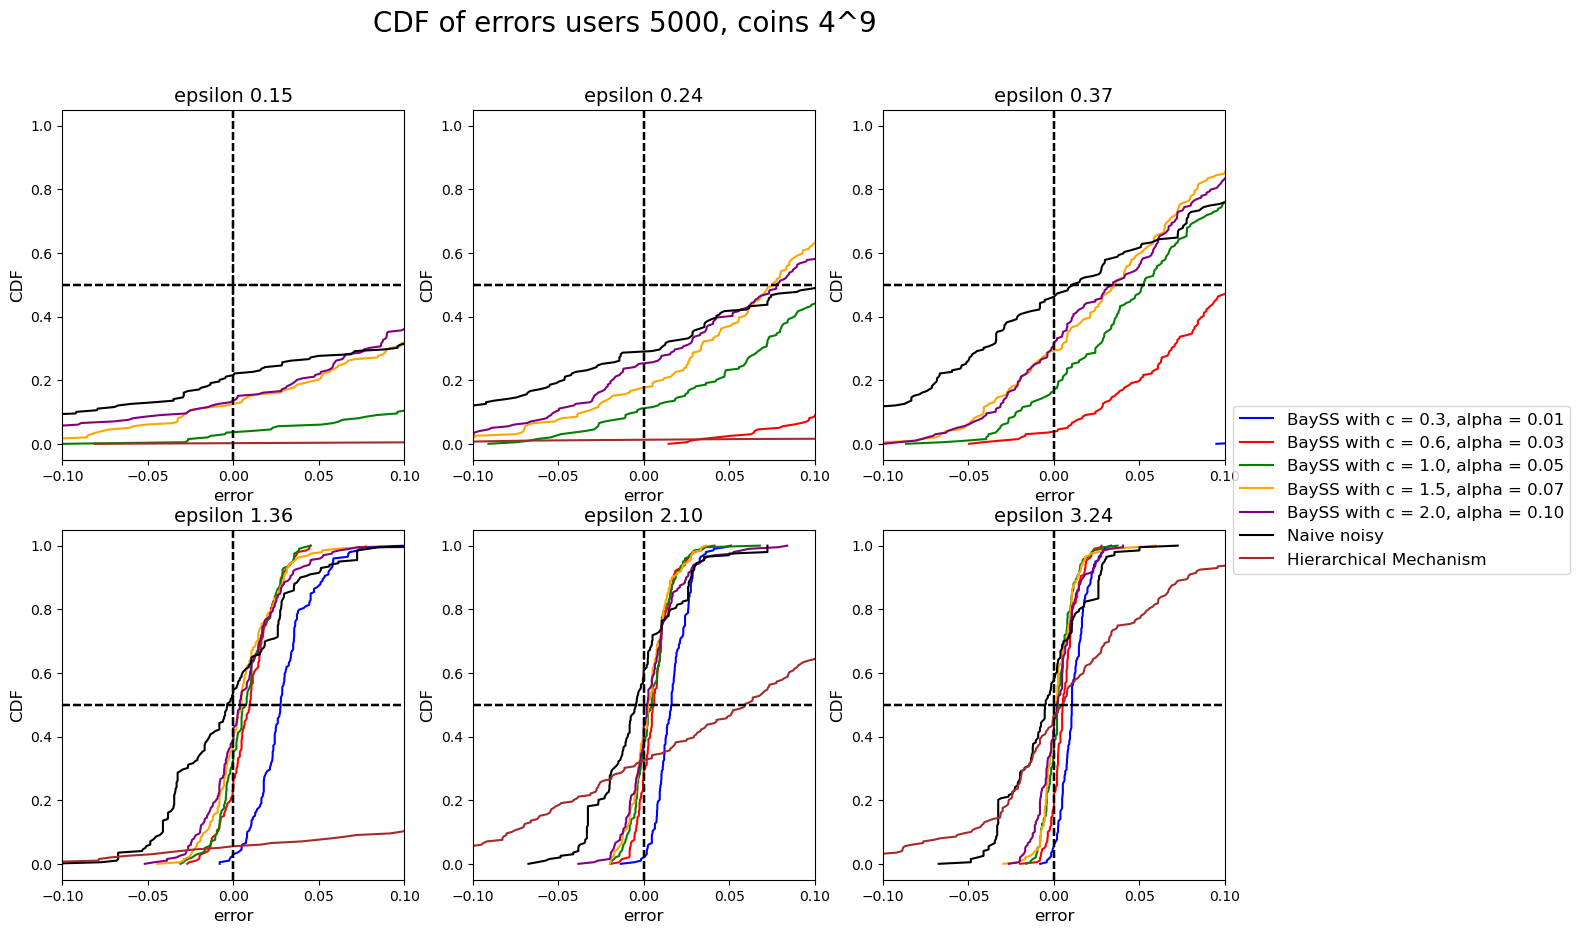

In [208]:
# make three plots in a row
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, eps_id in enumerate([1, 2, 3, 6, 7, 8]):
    ax = axs[i // 3, i % 3]  # Access subplot correctly
    
    eps = eps_list[eps_id]
    eps_id = eps_to_idx[eps]

    for j in range(len(c_list) + 2):
        errors = errors_list[j]
        errors = np.sort(errors[eps_id])
        errors = errors[::-1]
        ax.plot(errors, np.linspace(1, 0, len(errors)), label=label_list[j], color=colors[j])
        # print vertical line at 0
        ax.axvline(0, color='black', linestyle='--')
        # print horizontal line at 0.5
        ax.axhline(0.5, color='black', linestyle='--')
    ax.set_xlabel('error', fontsize=12)
    ax.set_ylabel('CDF', fontsize=12)
    ax.set_title(f"epsilon {eps:.2f}", fontsize = 14)
    # set x range in [-0.1, 0.1]
    ax.set_xlim([-0.1, 0.1])
    # set x ticks
    ax.set_xticks(np.linspace(-0.1, 0.1, 5))
# make unique legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=12)
fig.suptitle(f"CDF of errors users {N}, coins 4^{B_exp}", fontsize=20)

# save figure
folder_name = "final"
if not os.path.exists(f"figures/{folder_name}"):
    os.makedirs(f"figures/{folder_name}")
plt.savefig(f"figures/{folder_name}/cdf_N_{N}_B_exp_{B_exp}.png", bbox_inches='tight')

plt.show()

# CDF abs error

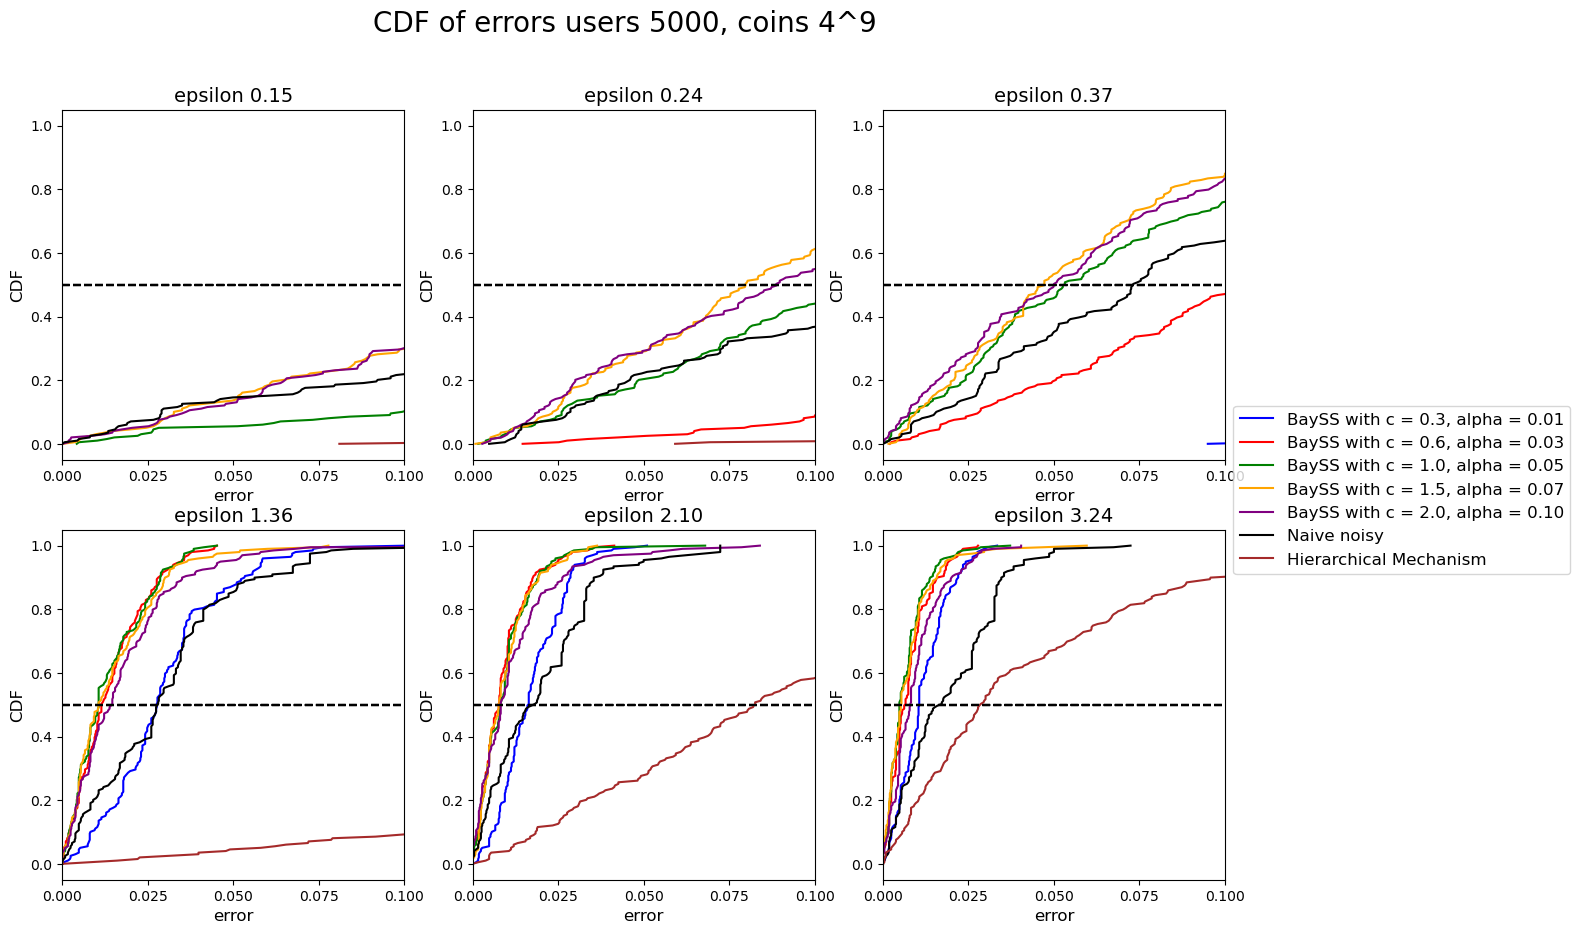

In [209]:
# make three plots in a row
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, eps_id in enumerate([1, 2, 3, 6, 7, 8]):
    ax = axs[i // 3, i % 3]  # Access subplot correctly
    
    eps = eps_list[eps_id]
    eps_id = eps_to_idx[eps]

    for j in range(len(c_list) + 2):
        errors = np.abs(errors_list[j])
        errors = np.sort(errors[eps_id])
        errors = errors[::-1]
        ax.plot(errors, np.linspace(1, 0, len(errors)), label=label_list[j], color=colors[j])
        # print vertical line at 0
        # ax.axvline(0, color='black', linestyle='--')
        # print horizontal line at 0.5
        ax.axhline(0.5, color='black', linestyle='--')
    ax.set_xlabel('error', fontsize=12)
    ax.set_ylabel('CDF', fontsize=12)
    ax.set_title(f"epsilon {eps:.2f}", fontsize = 14)
    # set x range in [-0.1, 0.1]
    ax.set_xlim([0.0, 0.1])
    # set x ticks
    ax.set_xticks(np.linspace(0.0, 0.1, 5))
# make unique legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=12)
fig.suptitle(f"CDF of errors users {N}, coins 4^{B_exp}", fontsize=20)

# save figure
folder_name = "final"
if not os.path.exists(f"figures/{folder_name}"):
    os.makedirs(f"figures/{folder_name}")
plt.savefig(f"figures/{folder_name}/abs_cdf_N_{N}_B_exp_{B_exp}.png", bbox_inches='tight')

plt.show()